# IQ modulation for Chirp

http://zone.ni.com/reference/en-XX/help/372058T-01/nirfsa/iq_modulation/

In [5]:
%matplotlib inline

from numpy import zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt, log10
from scipy.io.wavfile import write
from scipy.signal import spectrogram, butter, lfilter
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [133]:
#SAMPLING_RATE = 8000  # Hz
SAMPLING_RATE = 100000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = -1000
F2 = 1000

CARRIER=10000

WAVE_FILE="./ChirpTone.wav"

## Chirp tone synthesis

In [134]:
# Complex version of chirp tone generator
def chirp(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return exp(1j * arg) * amp

def chirp_IQ(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", iq='i', length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    if (iq == 'i'):
        return cos(arg) * amp
    elif (iq == 'q'):
        return sin(arg) * amp        

def carrier_IQ(freq=CARRIER, length=TIME_FRAME, amp=AMPLITUDE, iq='i'):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    arg = 2 * pi * freq * t
    if (iq == 'i'):
        return cos(arg) * amp
    elif (iq == 'q'):
        return sin(arg) * amp        

## FFT/IFFT functions

In [135]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")
    
    # Plot wave
def plot_wave(wave, logscale=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)

    if logscale:
        wave = 10 * log10(wave)
        plt.ylabel('Amplitude(dB)')
    else:
        plt.ylabel('Amplitude')

    plt.plot(t, wave)

    plt.xlabel('Time [sec]')
    plt.title("Time domain")

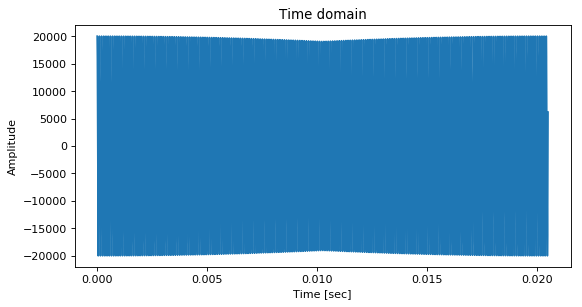

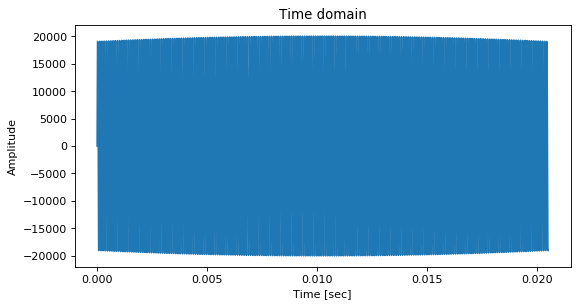

In [145]:
Ci = carrier_IQ(iq='i')
Cq = carrier_IQ(iq='q')
plot_wave(Ci)
plot_wave(Cq)

Frequencies at peaks: [-732.421875 -585.9375      0.        585.9375    732.421875] Hz


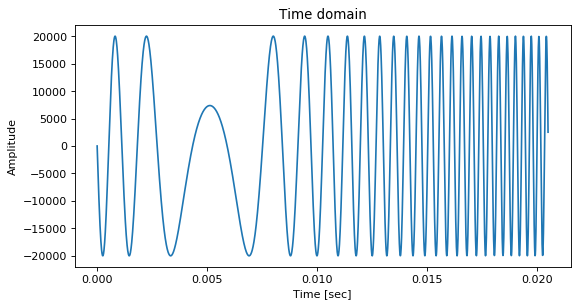

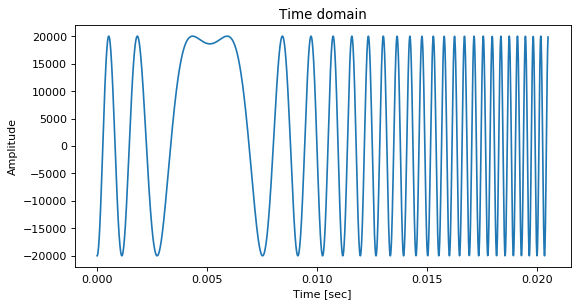

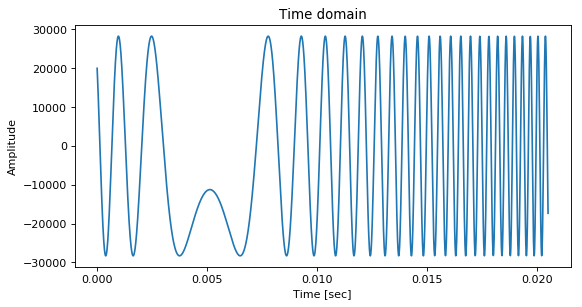

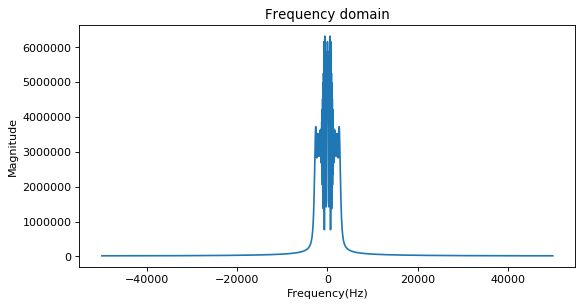

In [147]:
Bi = chirp_IQ(iq='i')
Bq = chirp_IQ(iq='q')
plot_wave(Bi)
plot_wave(Bq)
plot_wave(Bi-Bq)
plot_fft(Bi-Bq)

Frequencies at peaks: [-12646.484375  -9375.         9375.        12646.484375] Hz


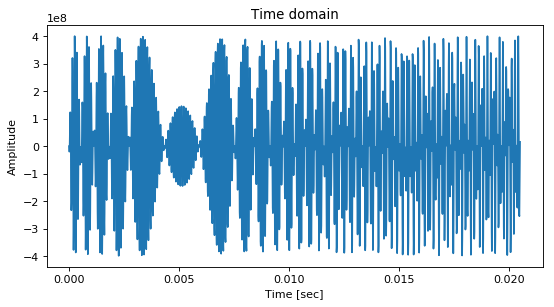

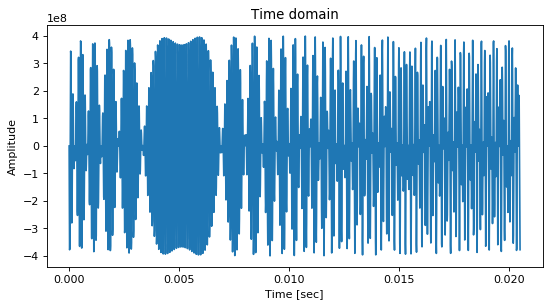

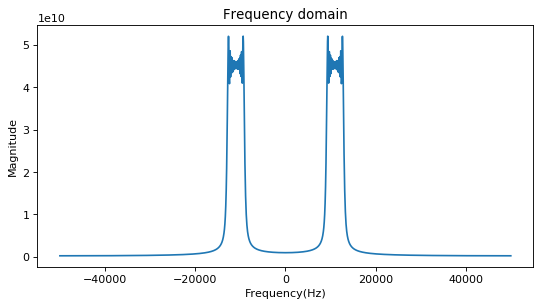

In [148]:
plot_wave(Bi*Ci)
plot_wave(Bq*Cq)
W = Bi*Ci - Bq*Cq
plot_fft(W)

Frequencies at peaks: [-585.9375   -341.796875  341.796875  585.9375  ] Hz
Frequencies at peaks: [-634.765625  634.765625] Hz


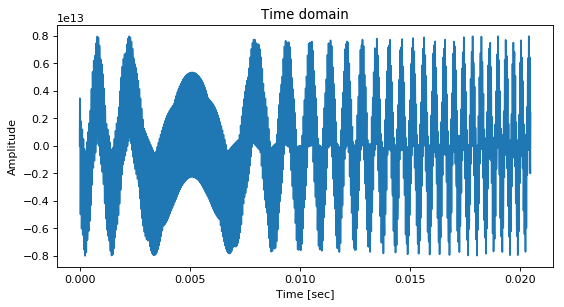

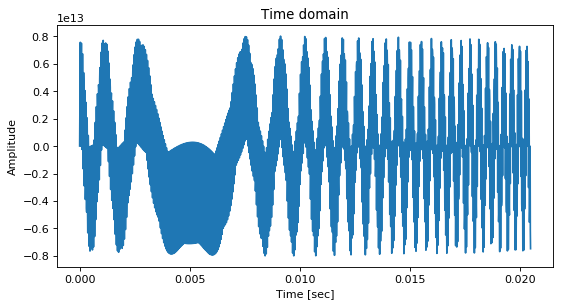

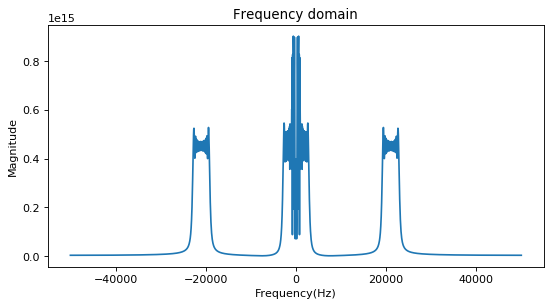

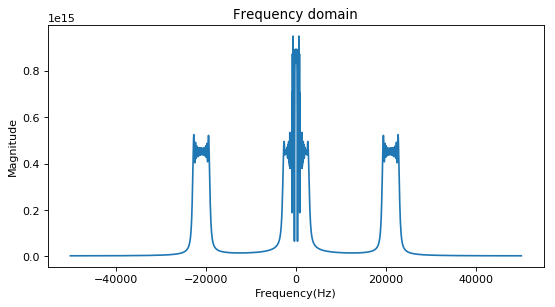

In [149]:
Ri = W*Ci
Rq = W*Cq
plot_wave(Ri)
plot_wave(Rq)
plot_fft(Ri)
plot_fft(Rq)

In [ ]:
# Add LPF to remove 2*10000Hz*t terms

Frequencies at peaks: [-2636.71875    634.765625 19384.765625 22607.421875] Hz
Frequencies at peaks: [0.] Hz


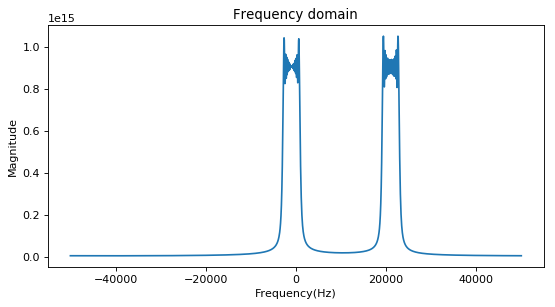

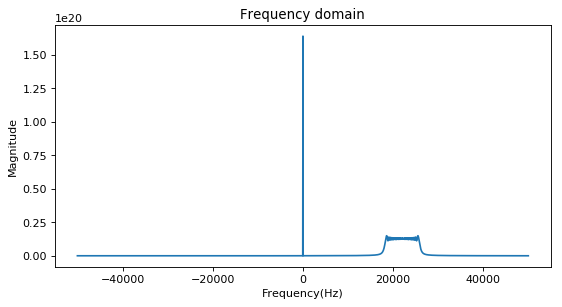

In [157]:
R = Ri + 1j * Rq
plot_fft(R)
plot_fft(R*chirp())